<a href="https://colab.research.google.com/github/hoodini/hackit-ai-transcriber/blob/main/HACKIT_AI_Transcriber_with_Speakers_%2B_BONUS_Hebrew_TTS!!.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

המחברת הזו נסמכת על קוד שמצאתי שמתמלל באמצעות וויספר של אופן איי.איי ומשתמש בחבילת פייתון לזיהוי דוברים. וכבונוס כיפי, הוספתי מודל טקסט לדיבור בעברית איכותית בסוף המחברת כך שתוכלו להוסיף טקסט מנוקד בעברית וליצור גם הקלטות בעברית עם מודל איכותי מאוד.

שדרגתי את המחברת, הוספתי אפשרות של הזנת קישור מיוטיוב, בחירת עברית כשפת קלט, שימוש במודל גדול יותר של וויספר שאמור להיות איכותי יותר. הוספתי קבצי תמלול ופיצלתי את הפלט לשבע מילים לשורה.

בנוסף, אני בודק את מגבלת גודל הקובץ של אופן איי.איי, אם גודל קובץ מעל עשרים וחמישה מגה, אני מפצל את הקובץ ומתמלל כל קובץ בנפרד.

מקווה שתפיקו ערך מהמחברת שלי, **עבדתי קשה עליה, מוזמנים לפרגן בבירה :***
https://www.buymeacoffee.com/hackit.co.il

ובנוסף, מצרף קישור לכל הקהילות שלי - **הצטרפו לקהילות שלי!**
https://linktree.com/hackit.co.il

**יובל אבידני
מייסד HACKIT.CO.IL**

הערות לתשומת לבכם:
1. בהגדרות יש לבחור:
Runtime -> Change Runtime Type -> A100/V100 (+ High RAM), ייתכן שהמחברת לא תרוץ כמו שצריך אם לא יהיו לכם יחידות עיבוד גרפיות, GPU, זמינות. במנוי פלוס מקבלים 90 יחידות עיבוד בחודש בעלות של כ-10$.
2. קבצי התמלול יישמרו בקבצים שבסרגל
3. ניתן לצרף קישור מיוטיוב או להעלות קובץ מדיה
4. יש לציין את מספר הדוברים בהקלטה
5. יש לבחור עברית או אנגלית לתוצאות מהירות יותר, אם מדובר בשפה אחרת, אל תציינו שפה
6. המחברת מתקינה את WHISPER של OPENAI בזמן הריצה. זה אומר שברגע שאתם מסיימים את השימוש במחברת וסוגרים אותה, תצטרכו להבא להריץ מחדש את כל התאים, שזה אומר בעצם להתקין מחדש את כל החבילות. זה לא סיפור, אבל שתדעו שהכל נמחק בסוף אז תשמרו הכל לפני שאתם מסיימים.
7. שימו לב להעתיק את המחברת לדרייב שלכם!

**שלב 1: התקנת חבילות**

In [14]:
!pip install pytube
!pip install -q git+https://github.com/openai/whisper.git > /dev/null
!pip install -q git+https://github.com/pyannote/pyannote-audio > /dev/null
!pip install librosa
!pip install tqdm

from tqdm import tqdm
import whisper
import datetime
import librosa
import subprocess
import os
import torch
import pyannote.audio
from pyannote.audio.pipelines.speaker_verification import PretrainedSpeakerEmbedding
embedding_model = PretrainedSpeakerEmbedding(
    "speechbrain/spkrec-ecapa-voxceleb",
    device=torch.device("cuda"))

from pyannote.audio import Audio
from pyannote.core import Segment

import wave
import contextlib

from sklearn.cluster import AgglomerativeClustering
import numpy as np

**שלב 2: בחירת סוג מדיה - קישור יוטיוב או העלאת קובץ**

In [15]:
from pytube import YouTube
import os
from math import ceil
import subprocess
import contextlib
import wave

input_option = "Media URL" #@param ["Media URL", "Upload File"]

if input_option == "Media URL":
    media_url = "https://www.youtube.com/watch?v=_3bexQni51U" #@param {type:"string"}
    path = media_url

    if path.strip():
        # Download the media file using pytube
        yt = YouTube(path)
        ys = yt.streams.get_highest_resolution()

        # Download the video
        video_file = ys.download(filename=ys.title.replace(" ", "_"))
        path = video_file  # Updating the 'path' variable to hold the file path of the downloaded video
        print(f"Download completed! File saved as {path}")

        # Check the file size
        file_size = os.path.getsize(path)
        chunk_size = 25 * 1024 * 1024  # 25 MB in bytes

        # Create a list to store paths to all files (or chunks)
        paths = [path]

        if file_size > chunk_size:
            # Split the file into chunks
            paths = []  # Reset the list to hold paths to chunks
            with open(path, 'rb') as f:
                file_num = 0
                for i in range(ceil(file_size / chunk_size)):
                    chunk_path = f'{path.replace(" ", "_")}_{file_num}.chunk'
                    with open(chunk_path, 'wb') as chunk_file:
                        chunk_file.write(f.read(chunk_size))
                    paths.append(chunk_path)  # Add chunk path to the list
                    file_num += 1
            print(f"The file was split into {file_num} chunks.")

        # Convert all media files to 'wav' format and delete the original files
        new_paths = []
        for p in paths:
            if p[-3:] != 'wav':
                new_file_path = f'{p}.wav'
                subprocess.call(['ffmpeg', '-i', p, new_file_path, '-y'])
                new_paths.append(new_file_path)
                os.remove(p)  # Remove the original file after converting
            else:
                new_paths.append(p)

        # Calculate the duration of each .wav file
        for p in new_paths:
            with contextlib.closing(wave.open(p,'r')) as f:
                frames = f.getnframes()
                rate = f.getframerate()
                duration = frames / float(rate)
                print(f"Duration of file {p}: {duration} seconds")
    else:
        print("Media URL is empty. Please enter a valid URL.")
elif input_option == "Upload File":
    from google.colab import files
    uploaded = files.upload()
    path = next(iter(uploaded))

print(path, paths, new_paths)

Download completed! File saved as /content/הדגמה:_יצירת_בסיס_לדף_נחיתה_עם_AutoGPT_ב-2_דקות!
Duration of file /content/הדגמה:_יצירת_בסיס_לדף_נחיתה_עם_AutoGPT_ב-2_דקות!.wav: 153.01950113378686 seconds
/content/הדגמה:_יצירת_בסיס_לדף_נחיתה_עם_AutoGPT_ב-2_דקות! ['/content/הדגמה:_יצירת_בסיס_לדף_נחיתה_עם_AutoGPT_ב-2_דקות!'] ['/content/הדגמה:_יצירת_בסיס_לדף_נחיתה_עם_AutoGPT_ב-2_דקות!.wav']


**שלב 3: בחירת מספר דוברים ושפת מקור (אין צורך לשנות את גודל המודל)**

In [16]:
num_speakers = 1 #@param {type:"integer"}

language = 'Hebrew' #@param ['any', 'English', 'Hebrew']

model_size = 'large' #@param ['tiny', 'base', 'small', 'medium', 'large']

model_name = model_size
if language == 'English' and model_size != 'large':
  model_name += '.en'
elif language == 'Hebrew':
  model_name += '.he'


**שלב 4: הרצת הגדרות נוספות ויצירת קבצי תמלול בפורמט TXT ו-SRT**

שימו לב - מאחר ואני משתמש במחברת במודל הגדול של התמלול, שלב זה יכול לקחת כמה דקות טובות, תלוי באורך הסרטון \ קובץ שבחרתם. אז אנא התאזרו בסבלנות.

In [17]:
# create an instance of the Audio class
audio = Audio()

model = whisper.load_model(model_size)

# Dictionary to store raw transcriptions
raw_transcriptions = {}

# Initializing an empty list to store all texts
all_texts = []

# Function to embed segments
def segment_embedding(segment, audio_path, audio_duration):
  start = segment["start"]
  end = min(audio_duration, segment["end"])
  clip = Segment(start, end)
  waveform, sample_rate = audio.crop(audio_path, clip)

  # Convert the waveform to mono here
  mono_waveform = librosa.to_mono(waveform.numpy())

  # Adding an extra dimension to represent the channel
  mono_waveform = mono_waveform[None, :]

  return embedding_model(torch.tensor(mono_waveform)[None])

# Function to format time for TXT transcript
def time(secs):
  return datetime.timedelta(seconds=round(secs))

# Function to format time for SRT transcript
def time_srt(secs):
    return str(datetime.timedelta(seconds=round(secs)))

# Process each path in new_paths
for p in tqdm(new_paths, desc="Processing files", unit="file"):
    result = model.transcribe(p)
    segments = result["segments"]

    # Save the raw transcription to the dictionary
    base_name = os.path.basename(p)
    base_name_no_ext = os.path.splitext(base_name)[0]
    raw_transcriptions[base_name_no_ext] = segments

    with contextlib.closing(wave.open(p,'r')) as f:
        frames = f.getnframes()
        rate = f.getframerate()
        duration = frames / float(rate)

    embeddings = np.zeros(shape=(len(segments), 192))
    for i, segment in enumerate(segments):
        embeddings[i] = segment_embedding(segment, p, duration)

    embeddings = np.nan_to_num(embeddings)

    clustering = AgglomerativeClustering(num_speakers).fit(embeddings)
    labels = clustering.labels_
    for i in range(len(segments)):
      segments[i]["speaker"] = 'SPEAKER ' + str(labels[i] + 1)

    # Create dynamic filenames for the transcript files
    base_name = os.path.basename(p)
    base_name_no_ext = os.path.splitext(base_name)[0]
    txt_filename = f"{base_name_no_ext}_transcript.txt"
    srt_filename = f"{base_name_no_ext}_transcript.srt"

    # Write the TXT transcript
    with open(txt_filename, "w") as f:
        for (i, segment) in enumerate(segments):
          if i == 0 or segments[i - 1]["speaker"] != segment["speaker"]:
            f.write("\n" + segment["speaker"] + ' ' + str(time(segment["start"])) + '\n')
          f.write(segment["text"][1:] + ' ')

    # Write the SRT transcript
    with open(srt_filename, "w") as f:
        for i, segment in enumerate(segments):
            # Write segment index
            f.write(f"{i+1}\n")

            # Write time range in SRT format (hh:mm:ss,mmm)
            start_time = time_srt(segment["start"]).split(':')
            end_time = time_srt(segment["end"]).split(':')
            f.write(f"{start_time[0]}:{start_time[1]}:{float(start_time[2]):06.3f} --> {end_time[0]}:{end_time[1]}:{float(end_time[2]):06.3f}\n")

            # Write speaker and text
            words = segment['text'][1:].split()
            for j in range(0, len(words), 7):
                f.write(f"{segment['speaker']}: {' '.join(words[j:j+7])}\n")

            # Add a blank line to separate different dialogues
            f.write("\n")

    # Print the data from the newly created SRT file
    with open(srt_filename, 'r') as file:
        data = file.read()

# Iterating over the keys in the raw_transcriptions dictionary
for key in raw_transcriptions:
    # Iterating over the list of segments in each entry
    for segment in raw_transcriptions[key]:
        # Extracting the 'text' field of each segment and adding it to the all_texts list
        all_texts.append(segment['text'])

# Joining all texts with a space to get a single string containing all texts
result_text = ' '.join(all_texts)

Processing files: 100%|██████████| 1/1 [00:50<00:00, 50.11s/file]


**שלב 5: הצגת התמלול (שימו לב שניתן להוריד את קבצי ה-TXT וה-SRT מהתפריט שבצד שמאל)**

In [18]:
print(data)

1
0:00:00.000 --> 0:00:12.000
SPEAKER 1: אז שלום חברים, כנראה אני עברה מהקייט
SPEAKER 1: ערוץ פודקאסט ובלוג הקייט בעברית והסרטון הזה
SPEAKER 1: יהיה מאוד מאוד זריז

2
0:00:12.000 --> 0:00:18.000
SPEAKER 1: אני רוצה להראות לכם איך שימוש באוטו,
SPEAKER 1: gpt יכול לחסוך לנו הרבה מאוד עבודה

3
0:00:18.000 --> 0:00:24.000
SPEAKER 1: אז כאן מה שאתם רואים זה המסך
SPEAKER 1: של אוטו gpt שיש לי סרטון אחר
SPEAKER 1: שכבר הדגמתי איך אנחנו מתקינים אותו

4
0:00:24.000 --> 0:00:29.000
SPEAKER 1: אני בעצם מגדיר את המטרות שלי, עכשיו
SPEAKER 1: שמרתי אותם כאן בצד אז אני רק
SPEAKER 1: אעתיק אותם לרגע

5
0:00:29.000 --> 0:00:37.000
SPEAKER 1: אני בעצם אומר לאוטו gpt ליצור לי
SPEAKER 1: עמוד נחיתה שבו אני רוצה למכור קורס
SPEAKER 1: של AI

6
0:00:37.000 --> 0:00:44.000
SPEAKER 1: אני מנסה להסביר לו להשתמש ב-HTML, CSS
SPEAKER 1: ו-JavaScript, האתר הזה צריך להיות אתר סטטי

7
0:00:44.000 --> 0:00:49.000
SPEAKER 1: אבל אני גם רוצה שהוא יהיה מותם
SPEAKER 1: למובייל, אני רוצה שהוא יהיה ריספונסיבי

8
0:00:49.000

In [19]:
result_text

' אז שלום חברים, כנראה אני עברה מהקייט ערוץ פודקאסט ובלוג הקייט בעברית והסרטון הזה יהיה מאוד מאוד זריז  אני רוצה להראות לכם איך שימוש באוטו, gpt יכול לחסוך לנו הרבה מאוד עבודה  אז כאן מה שאתם רואים זה המסך של אוטו gpt שיש לי סרטון אחר שכבר הדגמתי איך אנחנו מתקינים אותו  אני בעצם מגדיר את המטרות שלי, עכשיו שמרתי אותם כאן בצד אז אני רק אעתיק אותם לרגע  אני בעצם אומר לאוטו gpt ליצור לי עמוד נחיתה שבו אני רוצה למכור קורס של AI  אני מנסה להסביר לו להשתמש ב-HTML, CSS ו-JavaScript, האתר הזה צריך להיות אתר סטטי  אבל אני גם רוצה שהוא יהיה מותם למובייל, אני רוצה שהוא יהיה ריספונסיבי  דבר נוסף שאני ארצה זה שהוא ישמור לנו את הקבצים בעצם בפורמט של HTML, HTML, CSS, CSS, JavaScript, JavaScript  אני לא יודע אם זה יחיכי או לא אבל הרשמתי עכשיו עוד דבר נוסף שנתקלתי איתו הוא עניין המגבלה של הטוקנים  בגלל שהאוטו gpt מבוסס gpt 4 בהגדרה שלו אז זה בעצם 8,092 טוקנים  ומאחר ולי אין הרשאות אז הייתי צריך לשנות את הרשאה ל-gpt 3.5 טורבו שזה מה שאני בחרתי להשתמש בו  עכשיו תראו מה קרה אני הרצתי וברקע לא יודע אם שמתם 

# אופציונלי: יצירת הקלטה מהתמלול עם מודל קולי בעברית!

In [21]:
#@title Install Tacotron and Waveglow (click to see code)

import os
from os.path import exists, join, basename, splitext
!pip install gdown
git_repo_url = 'https://github.com/maxmelichov/tacotron2.git'
project_name = splitext(basename(git_repo_url))[0]
if not exists(project_name):
  # clone and install
  !git clone -q --recursive {git_repo_url}
  !cd {project_name}/waveglow && git checkout 2fd4e63
  !pip install -q librosa unidecode
  !pip install Hebrew

import sys
sys.path.append(join(project_name, 'waveglow/'))
sys.path.append(project_name)
import time
import matplotlib
import matplotlib.pylab as plt
import gdown
from hebrew import Hebrew
from hebrew.chars import HebrewChar, ALEPH
from hebrew import GematriaTypes
d = 'https://drive.google.com/uc?id='

#@title Install Tacotron pretrained model  (click to see code)
force_download_TT2 = True
tacotron2_pretrained_model = 'MLPTTS'
if not exists(tacotron2_pretrained_model) or force_download_TT2:
                   # ↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓ PUT MODEL HERE
  gdown.download(d+r'1Vee1F4q59G_YyEdXFz48ZJ7K-KBIincL&export=download', tacotron2_pretrained_model, quiet=False); print("Tacotron2 Model Downloaded")
                   # ↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑ PUT MODEL HERE

#@title Install Waveglow pretrained (click to see code)
waveglow_pretrained_model = 'waveglow.pt'
if not exists(waveglow_pretrained_model):
  gdown.download(d+r'1rpK8CzAAirq9sWZhe9nlfvxMF1dRgFbF&export=download', waveglow_pretrained_model, quiet=False); print("WaveGlow Model Downloaded")#1okuUstGoBe_qZ4qUEF8CcwEugHP7GM_b&export

!python ./tacotron2/waveglow/convert_model.py /content/waveglow.pt /content/waveglow.pt

import locale
locale.getpreferredencoding = lambda: "UTF-8"
locale.getpreferredencoding()

#@title Initialize Tacotron and Waveglow and Hebrew to English function
%matplotlib inline
import IPython.display as ipd
import numpy as np
import torch

from hparams import create_hparams
from model import Tacotron2
from layers import TacotronSTFT
from audio_processing import griffin_lim
from text import text_to_sequence
from denoiser import Denoiser

graph_width = 900
graph_height = 360
def plot_data(data, figsize=(int(graph_width/100), int(graph_height/100))):
    %matplotlib inline
    fig, axes = plt.subplots(1, len(data), figsize=figsize)
    for i in range(len(data)):
        axes[i].imshow(data[i], aspect='auto', origin='upper',
                       interpolation='none', cmap='inferno')
    fig.canvas.draw()
    plt.show()


import re

 ##deals with . and , in a normal string
def break_to_letter_and_rebuild(string):
    lst=[]
    i=0
    flag=False
    while i<len(string):
        tmp=""
        while i<len(string) and string[i] != '.' and string[i] != ',':
            tmp+=string[i]
            i+=1
            flag=True
        if flag:
            lst.append(tmp)
            flag=False
        if i<len(string):
            lst.append(string[i])
            i+=1

    return lst


##breaks down number to list
def breakdown(number):
    digits = []
    for place, value in zip([100000000,10000000, 1000000,100000, 10000,1000, 100, 10,1], [100000000,10000000, 1000000,100000, 10000,1000, 100, 10,1]):
        digit = number // place * value
        digits.append(digit)
        number -= digit
    return digits

##auxilary function for NumberToHebrew , helps break down arrays of 3's
def build_three_num_heb(list_num,num_dict_below_20,num_dict_eq_above_20,last):

    flag_zero=1
    list_heb=[]
    for i, num in enumerate(list_num):
        if num == 0:
            continue
        else:
            flag_zero=0
            if i < 1:
                list_heb.append(num_dict_eq_above_20[num])

            elif i == 1:
                if list_num[0] != 0:
                    if list_num[1] + list_num[2] < 20:
                        list_heb.append("וְ" + num_dict_below_20[list_num[1] + list_num[2]])
                        break
                    else:
                        list_heb.append(num_dict_eq_above_20[num])
                else:
                    if list_num[1] + list_num[2] < 20:
                        list_heb.append(num_dict_below_20[list_num[1] + list_num[2]])
                        break
                    else:
                        list_heb.append(num_dict_eq_above_20[num])

            elif i == 2:
                if list_num[0] != 0 or list_num[1] != 0 or last:
                    list_heb.append("וְ" + num_dict_below_20[num])
                else:
                    list_heb.append(num_dict_below_20[num])

    return list_heb,flag_zero

##gets number and turns it into hebrew with nikud
def NumberToHebrew(number):

    if number==0:
        return ["אֶפֶס"]

    signs_dict = {
        '%': 'אָחוּז',
        ',': 'פְּסִיק',
        '.': 'נְקֻדָּה'

    }

    num_dict_below_20={
        1: 'אֶחָד',
        2: 'שְׁנַיִם',
        3: 'שְׁלֹשָׁה',
        4: 'אַרְבָּעָה',
        5: 'חֲמִשָּׁה',
        6: 'שִׁשָּׁה',
        7: 'שִׁבְעָה',
        8: 'שְׁמוֹנָה',
        9: 'תִּשְׁעָה',
        10: 'עֶשֶׂר',
        11: 'אַחַד עָשָׂר',
        12: 'שְׁנֵים עָשָׂר',
        13: 'שְׁלֹשָׁה עָשָׂר',
        14: 'אַרְבָּעָה עָשָׂר',
        15: 'חֲמִשָּׁה עָשָׂר',
        16: 'שִׁשָּׁה עָשָׂר',
        17: "שִׁבְעָה עֶשְׂרֵה",
        18: "שְׁמוֹנָה עֶשְׂרֵה",
        19: "תִּשְׁעָה עֶשְׂרֵה"
    }

    num_dict_eq_above_20={
        20: "עֶשְׂרִים",
        30: "שְׁלשִׁים",
        40: "אַרְבָּעִים",
        50: "חֲמִשִּׁים",
        60: "שִׁשִּׁים",
        70: "שִׁבְעִים",
        80: "שְׁמוֹנִים",
        90: "תִּשְׁעִים",
        100: "מֵאָה",
        200: "מָאתַיִם",
        300: "שְׁלֹשׁ מֵאוֹת",
        400: "אַרְבָּעִ מֵאוֹת",
        500: "חֲמִשֶּׁ מֵאוֹת",
        600: "שֵׁשׁ מֵאוֹת",
        700: "שִׁבְעַ מֵאוֹת",
        800: "שְׁמוֹנֶ מֵאוֹת",
        900: "תִּשְׁעַ מֵאוֹת",
        1000: "אֶלֶף",
        2000: "אֲלַפַּיִם",
        3000: "שְׁלֹשֶׁת אֲלָפִים",
        4000: "אַרְבַּעַת אֲלָפִים",
        5000: "חֲמֵשׁ אֲלָפִים",
        6000: "שֵׁשׁ אֲלָפִים",
        7000: "שִׁבְעָה אֲלָפִים",
        8000: "שְׁמוֹנָה אֲלָפִים",
        9000: "תִּשְׁעָה אֲלָפִים"
    }

    if number in signs_dict:
        return [signs_dict[number]]

    if number<10000:

        list_heb=[]
        list_num=breakdown(number)
        list_num=list_num[5:]
        for i,num in enumerate(list_num):
            if num==0:
                continue
            else:
                if i<2:
                    list_heb.append(num_dict_eq_above_20[num])

                elif i==2:
                    if list_num[0]!=0 or list_num[1]!=0:
                        if list_num[2]+list_num[3]<20:
                            list_heb.append("וְ"+num_dict_below_20[list_num[2]+list_num[3]])
                            break
                        else:
                            list_heb.append(num_dict_eq_above_20[num])
                    else:
                        if list_num[2] + list_num[3] < 20:
                            list_heb.append(num_dict_below_20[list_num[2] + list_num[3]])
                            break
                        else:
                            list_heb.append(num_dict_eq_above_20[num])

                elif i==3:
                    if list_num[0]!=0 or list_num[1]!=0 or list_num[2]!=0:
                        list_heb.append("וְ" + num_dict_below_20[num])
                    else:
                        list_heb.append(num_dict_below_20[num])

        return list_heb

    else:

        list_heb = []
        list_num = breakdown(number)
        s1,s2,s3=list_num[:3],list_num[3:6],list_num[6:]



        ##take care of millions

        # set them up for transcript
        for i in range(len(s1)):
            s1[i]=s1[i]/1000000

        ret_list,flag_zero=build_three_num_heb(s1,num_dict_below_20,num_dict_eq_above_20,False)
        if not flag_zero:
            for item in ret_list:
                list_heb.append(item)
            list_heb.append("מִילְיוֹן")

        ##take care of thousands

        # set them up for transcript
        for i in range(len(s2)):
            s2[i] = s2[i] / 1000

        ret_list, flag_zero = build_three_num_heb(s2, num_dict_below_20, num_dict_eq_above_20,False)
        if not flag_zero:
            for item in ret_list:
                list_heb.append(item)
            list_heb.append("אֶלֶף")

        ##take care of hundred and leftovers
        ret_list, flag_zero = build_three_num_heb(s3, num_dict_below_20, num_dict_eq_above_20,True)
        if not flag_zero:
            for item in ret_list:
                list_heb.append(item)

        return list_heb



##attempts to split string to number and string
def split_number_and_string(input_string):
    # Use regular expression to find any number within the string
    match = re.search(r'\d+', input_string)

    if match:
        # Extract the number from the string
        number = match.group()

        # Split the string into two parts: before and after the number
        index = match.start()
        string_before_number = input_string[:index]
        string_after_number = input_string[index + len(number):]

        return string_before_number, number, string_after_number
    else:
        # If no number is found, return None
        return None

#######################################################################Auxilary functions



##check if string has number in it
def has_number(input_string):
    # Use regular expression to search for any digits within the string
    return bool(re.search(r'\d', input_string))

##breaks text to list
def break_to_list(text):
    """
    This function receives a string and returns a list of strings with each word from the input text.
    """
    lst = []
    for tav in text:
        lst.append(tav)
    return lst

####################################


########################## relevant for fixing text with numbers:

def is_number_with_comma(string):
    # Remove trailing comma, if any
    if string.endswith(',') or string.endswith('.'):
        string = string[:-1]

    # Check if string matches pattern
    if ',' in string:
        parts = string.split(',')
        if len(parts) != 2:
            return False
        if not all(part.isdigit() for part in parts):
            return False
    elif not string.isdigit():
        return False

    return True

def clean_number_with_comma(string):
    # Remove trailing comma, if any
    if string.endswith(',') or string.endswith('.'):
        string = string[:-1]

    # Remove commas from string
    string = string.replace(',', '')

    # Convert string to integer and return
    return int(string)


def is_number_with_decimal(string):
    if ',' in string:
        if string[-1] != ',':
            return False
        string = string[:-1]
    if '.' not in string:
        return False
    try:
        float(string)
    except ValueError:
        return False
    return True

def clean_decimal(string):
    if ',' in string:
        if string[-1] != ',':
            return None
        string = string[:-1]

    parts = string.split('.')
    try:
        return int(parts[0]),int(parts[1])
    except:
        return int(parts[0]),None


def is_percentage(string):

    if string[-1] == ',' or string[-1] == '.':
        string = string[:-1]

    if not string.endswith('%'):
        return False
    string = string[:-1]
    if string.endswith(','):
        string = string[:-1]
    try:
        float(string)
    except ValueError:
        return False
    return True


def clean_percentage(string):
    if string[-1] == ',' or string[-1] == '.':
        string = string[:-1]

    if string.endswith('%'):
        string = string[:-1]
    else:
        return None
    if ',' in string:
        if string[-1] != ',':
            return None
        string = string[:-1]
    try:
        number = float(string)
    except ValueError:
        return None
    return str(number).rstrip('0').rstrip('.')

def is_number_range(string):


    if '-' not in string:
        return False

    if string[-1] == ',' or string[-1] == '.':
        string = string[:-1]


    parts = string.split('-')
    if len(parts) != 2:
        return False
    for part in parts:
        if not part.isdigit():
            return False
    return True

def clean_number_range(string):
    if string[-1] == ',' or string[-1] == '.':
        string = string[:-1]

    parts = string.split('-')
    return (int(parts[0]), int(parts[1]))


def is_pattern_number_with_heb(string):
    if '-' not in string:
        return False

    if string[-1] == ',' or string[-1] == '.':
        string = string[:-1]

    parts = string.split('-')

    if not parts[1].isdigit() and not is_number_range(parts[1]) and not is_number_with_comma(parts[1]) and not is_number_with_decimal(parts[1]) and not is_percentage(parts[1]):
            return False

    return True

def clean_pattern_number_with_heb(string):
    if string[-1] == ',' or string[-1] == '.':
        string = string[:-1]

    parts = string.split('-')
    if len(parts)<=2:
        ## '4,000,' / '10,000' / '1000,'
        if is_number_with_comma(parts[1]):
            return parts[0],str(clean_number_with_comma(parts[1])) , "is_number_with_comma"

        ## '2.9' / '3.4'
        elif is_number_with_decimal(parts[1]):
            return parts[0],clean_decimal(parts[1]) , "is_number_with_decimal"

        ## '4.5%' / '9.25%.' / '26.5%,'
        elif is_percentage(parts[1]):
            return parts[0],str(clean_percentage(parts[1])) , "is_percentage"

    ## '5-6' / '1971-1972,' / '2003-2005.'
    if len(parts)>2 and is_number_range(parts[1]+'-'+parts[2]):
        return parts[0],(str(parts[1]),str(parts[2])) , "is_number_range"



def clean_number(word):

    ## '4,000,' / '10,000' / '1000,'
    if is_number_with_comma(word):
        return NumberToHebrew(int(clean_number_with_comma(word)))

    ## '2.9' / '3.4'
    elif is_number_with_decimal(word):
        list_heb=[]
        part1,part2=clean_decimal(word)
        list_heb+=NumberToHebrew(part1)
        list_heb+=NumberToHebrew('.')
        list_heb+=NumberToHebrew(part2)
        return list_heb

    ## '4.5%' / '9.25%.' / '26.5%,'
    elif is_percentage(word):
        list_heb = []
        part1, part2 = clean_decimal(clean_percentage(word))

        if part2!=None:
            list_heb += NumberToHebrew(part1)
            list_heb += NumberToHebrew('.')
            list_heb += NumberToHebrew(part2)
            list_heb += NumberToHebrew('%')
            return list_heb
        else:
            list_heb += NumberToHebrew(part1)
            list_heb += NumberToHebrew('%')
            return list_heb

    ## '5-6' / '1971-1972,' / '2003-2005.'
    elif is_number_range(word):
        list_heb = []
        part1, part2 = clean_number_range(word)
        list_heb += NumberToHebrew(part1)
        list_heb.append("עַד")
        list_heb += NumberToHebrew(part2)
        return list_heb

    ##    'בְּ-100,000'   / בְּ-99.99%  / הַ-1,100  /   מִ-0.7%   /  לְ-1.9    /  כְּ-22,000.
    elif is_pattern_number_with_heb(word):
        heb_letter,num,func=(clean_pattern_number_with_heb(word))
        #arr_attr= (clean_pattern_number_with_heb(word))
        list_heb = []
        list_heb.append(heb_letter)

        if func=="is_number_with_comma":
            list_heb+=NumberToHebrew(int(num))
            return list_heb

        elif func=="is_number_with_decimal":
            part1, part2 = num
            list_heb += NumberToHebrew(part1)
            list_heb += NumberToHebrew('.')
            list_heb += NumberToHebrew(part2)
            return list_heb

        elif func=="is_percentage":
            part1, part2 = clean_decimal(num)

            if part2 != None:
                list_heb += NumberToHebrew(part1)
                list_heb += NumberToHebrew('.')
                list_heb += NumberToHebrew(part2)
                list_heb += NumberToHebrew('%')
                return list_heb
            else:
                list_heb += NumberToHebrew(part1)
                list_heb += NumberToHebrew('%')
                return list_heb

        elif func == "is_number_range":
            part1, part2 = num
            list_heb += NumberToHebrew(int(part1))
            list_heb.append("עַד")
            list_heb += NumberToHebrew(int(part2))
            return list_heb

#######################################################

##takes a letter in hebrew and returns the sound in english
def HebrewLetterToEnglishSound(obj,tzuptzik,last_letter=False):
    obj = Hebrew(obj).string
    # map the nikud symbols to their corresponding phenoms
    nikud_map = {"ָ": "a", "ַ": "a", "ֶ": "e", "ֵ": "e", "ִ": "i", "ְ": "", "ֹ": "o", "ֻ": "oo", 'ּ': "", 'ֲ': 'a'}


    beged_kefet_shin_sin = {
        ############ B
        "בּ": "b",
        "בְּ": "b",
        "בִּ": "bi",
        "בֹּ": "bo",
        "בֵּ": "be",
        "בֶּ": "be",
        "בַּ": "ba",
        "בָּ": "ba",
        "בֻּ": "boo",
        ############ G
        "גּ": "g",
        "גְּ": "g",
        "גִּ": "gi",
        "גֹּ": "go",
        "גֵּ": "ge",
        "גֶּ": "ge",
        "גַּ": "ga",
        "גָּ": "ga",
        "גֻּ": "goo",
        ########### D
        "דּ": "d",
        "דְּ": "d",
        "דִּ": "di",
        "דֹּ": "do",
        "דֵּ": "de",
        "דֶּ": "de",
        "דַּ": "da",
        "דָּ": "da",
        "דֻּ": "doo",
        ########### K
        "כּ": "k",
        "כְּ": "k",
        "כִּ": "ki",
        "כֹּ": "ko",
        "כֵּ": "ke",
        "כֶּ": "ke",
        "כַּ": "ka",
        "כָּ": "ka",
        "כֻּ": "koo",
        ############ P
        "פּ": "p",
        "פְּ": "p",
        "פִּ": "pi",
        "פֹּ": "po",
        "פֵּ": "pe",
        "פֶּ": "pe",
        "פַּ": "pa",
        "פָּ": "pa",
        "פֻּ": "poo",
        ############ T
        "תּ": "t",
        "תְּ": "t",
        "תִּ": "ti",
        "תֹּ": "to",
        "תֵּ": "te",
        "תֶּ": "te",
        "תַּ": "ta",
        "תָּ": "ta",
        "תֻּ": "too",
        ############ S
        "שׂ": "s",
        "שְׂ": "s",
        "שִׂ": "si",
        "שֹׂ": "so",
        "שֵׂ": "se",
        "שֶׂ": "se",
        "שַׂ": "sa",
        "שָׂ": "sa",
        "שֻׂ": "soo",
        ########### SH
        "שׁ": "sh",
        "שְׁ": "sh",
        "שִׁ": "shi",
        "שֹׁ": "sho",
        "שֵׁ": "she",
        "שֶׁ": "she",
        "שַׁ": "sha",
        "שָׁ": "sha",
        "שֻׁ": "shoo",
    }

    vav = {
        "וֵּו": "ve",
        "וּ": "oo",
        "וּו": "oo",
        "וֹ": "o",
        "וֹו": "oo",
        "וְ": "ve",
        "וֱו": "ve",
        "וִ": "vi",
        "וִו": "vi",
        "וַ": "va",
        "וַו": "va",
        "וֶ": "ve",
        "וֶו": "ve",
        "וָ": "va",
        "וָו": "va",
        "וֻ": "oo",
        "וֻו": "oo"
    }


    letters_map = {
        "א": "",
        "ב": "v",
        "ג": "g",
        "ד": "d",
        "ה": "hh",
        "ו": "v",
        "ז": "z",
        "ח": "h",
        "ט": "t",
        "י": "y",
        "כ": "h",
        "ל": "l",
        "מ": "m",
        "נ": "n",
        "ס": "s",
        "ע": "",
        "פ": "f",
        "צ": "ts",
        "ק": "k",
        "ר": "r",
        "ש": "sh",
        "ת": "t",
        "ן": "n",
        "ם": "m",
        "ף": "f",
        "ץ": "ts",
        "ך": "h",
    }

    patah_ganav={
        "חַ": "ah",
        "חָ": "ah",
        "הַ": "hha",
        "הָ": "hha",
        "עַ": "a",
        "עָ": "a",

    }

    tzuptzik_letters={
        ##G
        "ג": "j",
        "גְ": "j",
        "גִ": "ji",
        "גֹ": "jo",
        "גֵ": "je",
        "גֶ": "je",
        "גַ": "ja",
        "גָ": "ja",
        "גֻ": "joo",
        "גּ": "j",
        "גְּ": "j",
        "גִּ": "ji",
        "גֹּ": "jo",
        "גֵּ": "je",
        "גֶּ": "je",
        "גַּ": "ja",
        "גָּ": "ja",
        "גֻּ": "joo",

        ##ch
        "צ": "ch",
        "צְ": "ch",
        "צִ": "chi",
        "צֹ": "cho",
        "צֵ": "che",
        "צֶ": "che",
        "צַ": "cha",
        "צָ": "cha",
        "צֻ": "choo",

        ##ch
        "ץ": "ch",
        "ץְ": "ch",
        "ץִ": "chi",
        "ץֹ": "cho",
        "ץֵ": "che",
        "ץֶ": "che",
        "ץַ": "cha",
        "ץָ": "cha",
        "ץֻ": "choo",

        ##Z
        "ז": "zh",
        "זְ": "zh",
        "זִ": "zhi",
        "זֹ": "zho",
        "זֵ": "zhe",
        "זֶ": "zhe",
        "זַ": "zha",
        "זָ": "zha",
        "זֻ": "zhoo",
    }

    if last_letter:
        if obj in patah_ganav:
            return patah_ganav[obj]

    if tzuptzik==True:
        if obj in tzuptzik_letters:
            return tzuptzik_letters[obj]

    if obj in beged_kefet_shin_sin:
        return beged_kefet_shin_sin[obj]
    elif obj in vav:
        return vav[obj]
    else:
        lst = break_to_list(obj)
        string = ""
        for item in lst:
            if item in letters_map:
                string += letters_map[item]
            if item in nikud_map:
                string += nikud_map[item]

        return string


##takes hebrew word and turns it into the sound in english
def HebrewWordToEnglishSound(word,index):
    new_sentence=""
    hs = Hebrew(word)
    hs = Hebrew(list(hs.graphemes)).string
    for i, letter in enumerate(hs):

        tzuptzik = False
        if i < len(hs) - 1:
            if hs[i + 1] == '\'':
                tzuptzik = True

        tav = HebrewLetterToEnglishSound(letter, tzuptzik, i == len(hs) - 1)
        new_sentence += tav

    ##clean list:
    try:
        if new_sentence[-1] == 'y' and new_sentence[-2] == 'y':
            new_sentence = new_sentence.replace("yy", "y")
    except:
        pass
    return new_sentence

##takes hebrew sentence and turns it into english sounds
def ARPA(sentence,index=0):
    words = sentence.split()
    new_sentence = ""

    for word in words:
        ##if number not in string
        if not has_number(word):

            ##breaks the word to letters and ',' and '.'
            broken_word=break_to_letter_and_rebuild(word)

            for brk_word in broken_word:

                ##tries to add silence
                if brk_word=='.' or brk_word==',' or brk_word==';':
                    new_sentence += "q"+" "

                else:
                    ret_sentence=HebrewWordToEnglishSound(brk_word,index)
                    new_sentence+=ret_sentence+" "

        ##if there is a number:
        else:
            try:
                before_num,num,after_num=split_number_and_string(word)

                if has_number(after_num) or has_number(before_num):
                    list_of_numbers=clean_number(word)
                    for number in list_of_numbers:
                        ret_sentence = HebrewWordToEnglishSound(number, index)
                        new_sentence += ret_sentence + " "

                else:
                    ret_sentence = HebrewWordToEnglishSound(before_num, index)
                    new_sentence += ret_sentence+" "

                    num = [s for s in word if s.isdigit()]
                    num="".join(num)
                    num=int(num)
                    list_of_numbers=NumberToHebrew(num)
                    for number in list_of_numbers:
                        ret_sentence=HebrewWordToEnglishSound(number,index)
                        new_sentence += ret_sentence + " "

                    ret_sentence = HebrewWordToEnglishSound(after_num, index)
                    new_sentence += ret_sentence + " "



            except:
                print("error from split_number_and_string in line:", index,"with word: ",word)



    return new_sentence

torch.set_grad_enabled(False)

# initialize Tacotron2 with the pretrained model
hparams = create_hparams()

# Load Tacotron2 (run this cell every time you change the model)
hparams.sampling_rate = 22050 # Don't change this
hparams.max_decoder_steps = 1800 # How long the audio will be before it cuts off (1000 is about 11 seconds)
hparams.gate_threshold = 0.1 # Model must be 90% sure the clip is over before ending generation (the higher this number is, the more likely that the AI will keep generating until it reaches the Max Decoder Steps)
model = Tacotron2(hparams)
model.load_state_dict(torch.load(tacotron2_pretrained_model)['state_dict'])
_ = model.cuda().eval()

# Load WaveGlow
waveglow = torch.load(waveglow_pretrained_model)['model']
waveglow.cuda().eval()
for k in waveglow.convinv:
    k.float()
denoiser = Denoiser(waveglow)

Downloading...
From: https://drive.google.com/uc?id=1Vee1F4q59G_YyEdXFz48ZJ7K-KBIincL&export=download
To: /content/MLPTTS
100%|██████████| 338M/338M [00:02<00:00, 150MB/s]


Tacotron2 Model Downloaded


אָז שָׁלוֹם חֲבֵרִים, אֲנִי יוּבָל מֵהָאק אֵט עֲרוּץ פּוֹדְקַאסְט וּבְלֹג בִּינָה מְלָאכוּתִית וְהָאקִינְג בְּעִבְרִית וְהַסִּרְטוֹן הַזֶּה יִהְיֶה מְאוֹד מְאוֹד זָרִיז
az shalom haveriym q aniy yooval mehhak et aroots podkast oovlog biynahh mlahootiyt vehhakiyng bivriyt vehhasirton hhazehh yihhyehh mod mod zariyz 


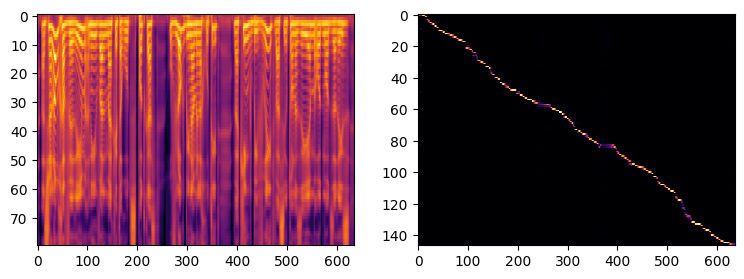

אֲנִי רוֹצֶה לְהַרְאוֹת לָכֶם אֵיךְ שִׁמּוּשׁ בְּאוֹטוֹ גִ'י פִּי טִי יָכוֹל לַחֲסֹךְ לָנוּ הַרְבֵּה מְאוֹד עֲבוֹדָה.
aniy rotsehh lhharot lahem eyh shimoosh boto jiy piy tiy yahol lahasoh lanoo hharbehh mod avodahh q 


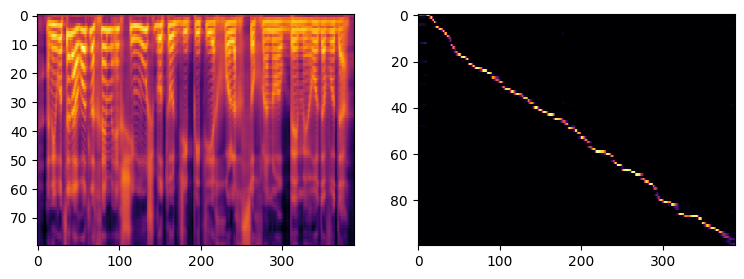

אָז כָּאן מָה שֶׁאַתֶּם רוֹאִים זֶה הַמָּסָךְ שֶׁל אוֹטוֹ גִ'י פִּי טִי,
az kan mahh sheatem roiym zehh hhamasah shel oto jiy piy tiy q 


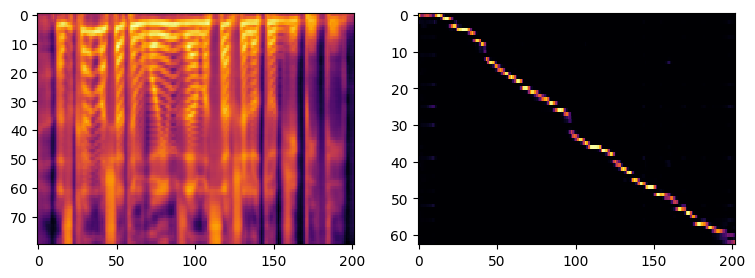

טִישֶׁיֵּשׁ לִי סִרְטוֹן אַחֵר שֶׁכְּבָר הִדְגַּמְתִּי אֵיךְ אֲנַחְנוּ מַתְקִינִים אוֹתוֹ  אֲנִי בְּעֶצֶם מַגְדִּיר אֶת הַמַּטָּרוֹת שֶׁלִּי, 
tiysheyesh liy sirton aher shekvar hhidgamtiy eyh anahnoo matkiyniym oto aniy betsem magdiyr et hhamatarot sheliy q 


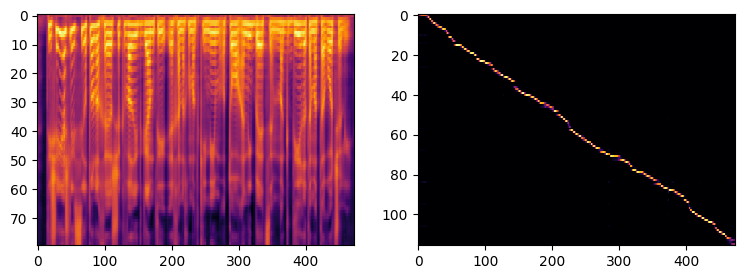

עַכְשָׁו שָׁמַרְתִּי אוֹתָם כָּאן בַּצַּד אָז אֲנִי רַק אַעְתִּיק אוֹתָם לְרֶגַע,
ahshav shamartiy otam kan batsad az aniy rak atiyk otam lrega q 


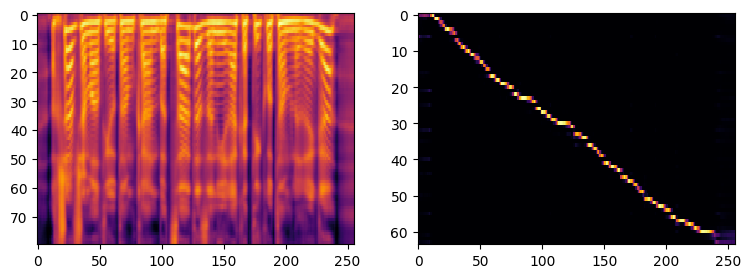

אֲנִי בְּעֶצֶם אוֹמֵר לָאוֹטוֹ גִ'י פִּי טִי לִיצָר לִי עַמּוּד נְחִיתָה שֶׁבּוֹ אֲנִי רוֹצֶה לִמְכֹּר קוּרְס שֶׁל בִּינָה מְלָאכוּתִית, 
aniy betsem omer laoto jiy piy tiy liytsar liy amood nhiytahh shebo aniy rotsehh limkor koors shel biynahh mlahootiyt q 


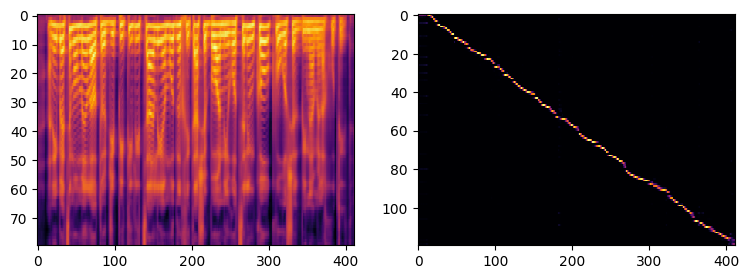

אֲנִי מְנַסֶּה לְהַסְבִּיר לוֹ לְהִשְׁתַּמֵּשׁ בְּקוֹד
aniy mnasehh lhhasbiyr lo lhhishtamesh bkod 


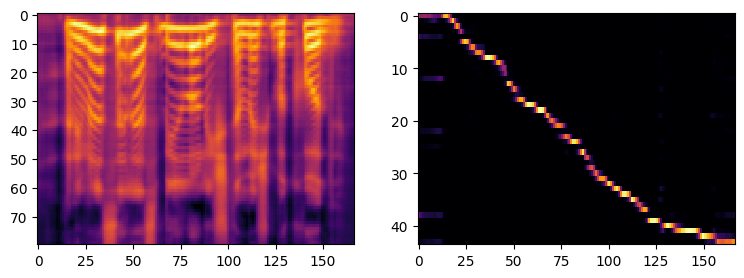

In [23]:

#This is the text that will be created as audio, feel free to change it

text = """
אָז שָׁלוֹם חֲבֵרִים, אֲנִי יוּבָל מֵהָאק אֵט עֲרוּץ פּוֹדְקַאסְט וּבְלֹג בִּינָה מְלָאכוּתִית וְהָאקִינְג בְּעִבְרִית וְהַסִּרְטוֹן הַזֶּה יִהְיֶה מְאוֹד מְאוֹד זָרִיז
אֲנִי רוֹצֶה לְהַרְאוֹת לָכֶם אֵיךְ שִׁמּוּשׁ בְּאוֹטוֹ גִ'י פִּי טִי יָכוֹל לַחֲסֹךְ לָנוּ הַרְבֵּה מְאוֹד עֲבוֹדָה.
אָז כָּאן מָה שֶׁאַתֶּם רוֹאִים זֶה הַמָּסָךְ שֶׁל אוֹטוֹ גִ'י פִּי טִי,
טִישֶׁיֵּשׁ לִי סִרְטוֹן אַחֵר שֶׁכְּבָר הִדְגַּמְתִּי אֵיךְ אֲנַחְנוּ מַתְקִינִים אוֹתוֹ  אֲנִי בְּעֶצֶם מַגְדִּיר אֶת הַמַּטָּרוֹת שֶׁלִּי,
עַכְשָׁו שָׁמַרְתִּי אוֹתָם כָּאן בַּצַּד אָז אֲנִי רַק אַעְתִּיק אוֹתָם לְרֶגַע,
אֲנִי בְּעֶצֶם אוֹמֵר לָאוֹטוֹ גִ'י פִּי טִי לִיצָר לִי עַמּוּד נְחִיתָה שֶׁבּוֹ אֲנִי רוֹצֶה לִמְכֹּר קוּרְס שֶׁל בִּינָה מְלָאכוּתִית,
אֲנִי מְנַסֶּה לְהַסְבִּיר לוֹ לְהִשְׁתַּמֵּשׁ בְּקוֹד
"""

sigma = 0.8
denoise_strength = 0.2
# try to switch raw data to True maybe the results will be better
raw_input = False # disables automatic ARPAbet conversion, useful for inputting your own ARPAbet pronounciations or just for testing

for i in text.split("\n"):
    if len(i) < 1: continue;
    print(i)
    if raw_input:
        if i[-1] != ";": i=i+";"
    else: i = ARPA(i)
    print(i)
    with torch.no_grad(): # save VRAM by not including gradients
        sequence = np.array(text_to_sequence(i, ['english_cleaners']))[None, :]
        sequence = torch.autograd.Variable(torch.from_numpy(sequence)).cuda().long()
        mel_outputs, mel_outputs_postnet, _, alignments = model.inference(sequence)
        plot_data((mel_outputs_postnet.float().data.cpu().numpy()[0],alignments.float().data.cpu().numpy()[0].T))
        audio = waveglow.infer(mel_outputs_postnet, sigma=sigma); print(""); ipd.display(ipd.Audio(audio[0].data.cpu().numpy(), rate=hparams.sampling_rate))